<a href="https://colab.research.google.com/github/someshjaishwal/object-detection/blob/master/vr_assign_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ----------- My Preferences -------------------
---



In [0]:
from google.colab import drive
drive.mount('/gdrive')
gdrive = '/gdrive/My\ Drive'

!ls $gdrive/

# ----------- Begin Assignment ---------------

# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [0]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import xml.etree.ElementTree
from PIL import Image
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
import imutils
from sklearn.utils import class_weight as cw
from shutil import copy2
import matplotlib.pyplot as plt

# vision specific 


import cv2
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = 256#size of resnet18 input images


## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [0]:
# Choose your hyper-parameters using validation data
batch_size = 50
num_epochs = 20
learning_rate =  0.001
hyp_momentum = 0.9

In [0]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

In [0]:
nbg_per_img = 1
nbg_threshold = 150
bg_h = 56
bg_w = 56

                             
def build_dataset(path, set_):
  
    dataset_path = 'dataset/'+ set_ +'/'
    
    count = {'__background__' : 0,
           'aeroplane' : 0,
           'bottle' : 0,
           'chair' : 0
        }

    print(dataset_path)
    
    # build dataset
    !mkdir images images/$set_ images/$set_/imgs images/$set_/xmls
    !mkdir dataset dataset/$set_ dataset/$set_/aeroplane dataset/$set_/bottle dataset/$set_/chair dataset/$set_/'__background__'
    xmlstore_path = os.path.join(path, 'Annotations')
    imgstore_path = os.path.join(path, 'JPEGImages')
    imgs = os.listdir(imgstore_path)

    imgs.sort()
    for img in imgs:
        # take image
        image = cv2.imread(os.path.join(imgstore_path, img))
        saved_once = False
        
        # take object names and respective locations in this image
        img_xml_path = os.path.join(xmlstore_path, img.split('.')[0] + '.xml')
        e = xml.etree.ElementTree.parse(img_xml_path).getroot()
        obj_locs = []
        for obj in e.iter('object'):
            if obj.find('name').text in classes: 
                
                # save these images once
                if not saved_once:
                    path = 'images/' + set_ + '/'  
                    cv2.imwrite(os.path.join(path +'imgs/' + img), image)
                    copy2(img_xml_path , path + 'xmls')
                    saved_once = True
                
                # extract obj location
                count[obj.find('name').text] = count[obj.find('name').text] + 1              
                bnd_box = obj.find('bndbox')
                xmin = int(bnd_box.find('xmin').text)
                ymin = int(bnd_box.find('ymin').text)
                xmax = int(bnd_box.find('xmax').text)
                ymax = int(bnd_box.find('ymax').text)

                patch = image[ymin:ymax, xmin:xmax]
                
                # save object to dataset/it's_class
                cv2.imwrite(os.path.join(dataset_path + obj.find('name').text,
                                         str(count[obj.find('name').text]) +'_' + img), patch)
                
                # collect object locations
                obj_locs.append([ymin, ymax, xmin, xmax])
          
        # get __background__ images
        if count['__background__'] <= nbg_threshold :
            bg_imgs = get_background(image, obj_locs, nbg_per_img)
            for bg_img in bg_imgs:
                count['__background__'] = count['__background__'] + 1
                
                # save __background__ images 
                cv2.imwrite(os.path.join(dataset_path + '__background__',
                                     str(count['__background__']) + '.jpeg'), bg_img)
    
    print('dataset build')

    
#    
# build dataset
#

train_path = 'VOCdevkit_train/VOC2007/'
test_path = 'VOCdevkit_test/VOC2007/'

remove_everything = 1
downloaded, get_from_drive = 0, 1

if remove_everything:
    !rm -r /content/*
    
if not downloaded:
    if get_from_drive:
        !tar -xf $gdrive/dataset/VOCtrainval_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_train
        !tar -xf $gdrive/dataset/VOCtest_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_test
    else:
        !wget 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
        !wget 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
        !tar -xf VOCtrainval_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_train
        !tar -xf VOCtest_06-Nov-2007.tar && mv VOCdevkit VOCdevkit_test
    

build_dataset(train_path, 'train')
build_dataset(test_path, 'test')


##Staging Data

In [0]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
  
    def __init__(self, image_paths, labels , mode, transform=None):
        # Begin
        
        # initialize img paths and labels
        self.image_paths = image_paths
        self.labels = labels
        
        # switch train mode
        self.train = mode
        
        # image transformations
        self.transform = transform
        self.train_transform = transforms.Compose([transforms.RandomRotation(45),
                                                   transforms.ColorJitter()])
        
        # randomize indices
        self.random_indices = np.arange(len(self.labels))
        np.random.shuffle(self.random_indices)
        
        # label-index  mapping
        self.label_index = {
            '__background__' : 0,
            'aeroplane' : 1,
            'bottle' : 2,
            'chair' : 3
           }
        
    def __len__(self):
        # Begin
        return len(self.labels)
        
    def __getitem__(self, idx):
        # Begin
        
        # get random index
        index = self.random_indices[idx]
        img_path = self.image_paths[index]
        
        # read img path at random index
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        
        # apply transformation
        if self.train == True:
            img = self.train_transform(img)
            
        img = self.transform(img)
        
        # return transformed img and label
        return img, torch.tensor(self.label_index[label])

In [0]:
# get train images path
image_paths, labels = get_path_and_labels(root_dir='./dataset/train')

# split training imgs path -> training, validation img paths
train_img_paths, val_img_paths, train_labels,  val_labels = train_test_split(image_paths,
                                                                              labels, 
                                                                              test_size = 0.05,
                                                                              random_state = 42)
# test img paths
test_img_paths, test_labels = get_path_and_labels(root_dir='./dataset/test')

In [0]:
# common transformations for test and train images
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
#
# stage dataset
#

# train, val, test dataset
train_dataset = voc_dataset(train_img_paths, train_labels, mode=True, transform=composed_transform) # Supply proper root_dir
val_dataset = voc_dataset(val_img_paths, val_labels, mode=False, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(test_img_paths, test_labels, mode=False, transform=composed_transform) # Supply proper root_dir

# train, val, test dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Build Model

In [0]:
# code for cuda
device = torch.device("cuda" if torch.cuda.is_available() 
                             else "cpu")

In [0]:
#
#      Model 1
#

# resnet18 convolutional base
model_1 = models.resnet18(pretrained=True)

# freeze conv base layers
for param in model_1.parameters():
    param.requires_grad = False
    
# fc's
model_1.fc = nn.Sequential(nn.Linear(model_1.fc.in_features, 512), #512
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512,4),
                           nn.LogSoftmax(dim=1))
model_1 = model_1.to(device)

In [0]:
#
#      Model 2
#


# resnet18 convolutional base
model_2 = models.resnet18(pretrained=True)
model_2 = nn.Sequential(*list(model_2.children())[:-3])

# freeze conv base layers
for param in model_2.parameters():
    param.requires_grad = False

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

# fc's
model_2 = nn.Sequential(model_2,
                       Flatten(),
                       nn.Linear(65536, 512), ### 65536 50176
                       nn.ReLU(),
                       nn.Dropout(0.4),
                       nn.Linear(512, 128),   
                       nn.ReLU(),
                       nn.Dropout(0.5),
                       nn.Linear(128,4),
                       nn.LogSoftmax(dim=1))

model_2 = model_2.to(device)

In [0]:
# model summaries
summary(model_1, (3, 256,256))
summary(model_2, (3, 256,256))

In [0]:
#
# class weights to mitigate unbalanced data
#

want_class_weights = 0

# uniform class weights
class_weights = np.array([1,1,1,1])


# class weights
if want_class_weights :
    class_weights = cw.compute_class_weight('balanced', np.unique(train_dataset.labels), train_dataset.labels)
    
class_weights = (torch.tensor(class_weights).float()).cuda()

In [0]:
# loss function and optimizer for model_1
criterion_model_1 = nn.NLLLoss(weight = class_weights)
optimizer_model_1 = optim.SGD(model_1.parameters(), learning_rate, hyp_momentum)

# loss function and optimizer for model_2
criterion_model_2 = nn.NLLLoss(weight = class_weights)
optimizer_model_2 = optim.SGD(model_2.parameters(), learning_rate, hyp_momentum)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [0]:
#
# train 'model' on data staged on 'train_loader', with validation data staged on val_loader
#

def train(model, train_loader, val_loader , criterion, optimizer, epochs, device):
    
    # details
    train_loss_, val_loss_ = [], []
    train_acc_ ,val_acc_ = [] , [] 
    
    # epochs
    for epoch in range(epochs):
        
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        val_loss = 0.0

        train_acc = 0.0
        val_acc = 0.0

        # Set to training and start timer
        model.train()
        # start = timer() 
       
        for ii, (batch, labels) in enumerate(train_loader):
            batch, labels = batch.to(device), labels.to(device)
     
            # clear grads
            optimizer.zero_grad()
            
            # output (prediction)
            output = model.forward(batch)
         
            # loss
            loss = criterion(output, labels)
            loss.backward()
            
            # back prop
            optimizer.step()
            
            # train loss
            train_loss += loss.item() * batch.size(0)
            
            # train accuracy
            output = torch.exp(output)
            top_prob , top_class = output.topk(1, dim=1)     # try remove dim!!
            equals = top_class == labels.view(*top_class.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
            train_acc += accuracy * batch.size(0)
        
        
        # Set to Evalution
        model.eval()
        with torch.no_grad():
            for ii, (batch, labels) in enumerate(val_loader):
                batch, labels = batch.to(device),labels.to(device)
                
                # output (prediction)
                output = model.forward(batch)
                
                # validation loss
                loss = criterion(output, labels)
                val_loss += loss.item() * batch.size(0)
                
                # validation accuracy
                output = torch.exp(output)
                top_prob , top_class = output.topk(1, dim=1)     # try remove dim!!
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
                val_acc += accuracy * batch.size(0)
                                
        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)

        # Calculate average accuracy
        train_acc = train_acc / len(train_loader.dataset)
        val_acc = val_acc / len(val_loader.dataset)
        
        # History saved
        train_loss_.append(train_loss)
        val_loss_.append(val_loss)
        
        train_acc_.append(train_acc)
        val_acc_.append(val_acc)
            
        # show loss and accuracy
        print('\nEpoch ' + str(epoch + 1) + ' | Train Loss : ' + str(train_loss) + ' : Val Loss : ' + str(val_loss))
        print('\t  '+ 'Train Acc : ' + str(train_acc) + ' : Val Accuracy : ' + str(val_acc))
    
    return train_loss_, val_loss_, train_acc_, val_acc_

In [0]:
%time train_loss_, val_loss_, train_acc_, val_acc_ = train(model_1, train_loader, val_loader, criterion_model_1, optimizer_model_1 , 20, device)

In [0]:
#
#   Plot model_1 estimations of loss and accuracy on training and validation set
#

plot_it(train_loss_,'training loss', val_loss_, 'validation loss', 'loss', 'Training and Validation Loss : model_1 '  )
plot_it(train_acc_,'training acc', val_acc_, 'validation acc', 'acc', 'Training and Validation acc  : model_1')

In [0]:
%time train_loss_, val_loss_, train_acc_, val_acc_  = train(model_2, train_loader, val_loader, criterion_model_2, optimizer_model_2 , 20, device)


In [0]:
#
#   Plot model_2 estimations of loss and accuracy on training and validation set
#


plot_it(train_loss_,'training loss', val_loss_, 'validation loss', 'loss', 'Training and Validation Loss : model_2'  )
plot_it(train_acc_,'training acc', val_acc_, 'validation acc', 'acc', 'Training and Validation acc : model_2')

In [0]:
#
# save models
#

torch.save(model_1, 'model_1_86.2')
torch.save(model_2, 'model_2_88')

!rm $gdrive/files/model_1
!rm $gdrive/files/model_2
!cp model_1_86.2 $gdrive/files
!cp model_2_88 $gdrive/files

In [0]:
#
# load models
#
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
    
fetch_from_drive = True
if fetch_from_drive:
    model_1 = torch.load('/gdrive/My Drive/files/model_1_cw_80_82_85')
    model_2 = torch.load('/gdrive/My Drive/files/model_2_cw_87_92_89')


In [0]:
summary(model_1,(3,256,256))
summary(model_2,(3,256,256))

In [0]:
#
# accuracy on test cropped objects
#
print('On model_1')
output_1 = predict(model_1, test_loader)

print('\nOn model_2')
output_2 = predict(model_2, test_loader)

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [0]:
#
#  Sliding Window techinque to get patches of supplied image
#

def sliding_window(image, stride, width):
    
    #aspect_ratios = [(1,1), (16,10), (10,16), (4,3),   (3,4),    (2,1) ,  (1,2)]
    window_sizes = [[width,width],
                    [width,width*10//16], [width*10//16,width],
                    #[width,width*3//4], [width*3//4,width],
                    [width, width//2], [width//2,width]]
    
    for ws in window_sizes:
        
        # check window doesn't exceed image boundaries
        if image.shape[0] < ws[1] or image.shape[1] < ws[0]:
            continue
           
        # prepare break if height of patch exceeds that of image
        break_prepared_h = False
        
        for h in range(0, image.shape[0], stride):
            ws_h = ws[1]
            
            # damp window height if it exceeds image boundary
            if  ws_h > image.shape[0] - h:
                ws_h = image.shape[0] - h
                break_prepared_h = True
                
            
            # prepare break if width of patch exceeds that of image
            break_prepared_w = False
            
            for w in range(0, image.shape[1], stride):
                ws_w = ws[0]
                
                # damp window width if it exceeds image boundary
                if  ws_w > image.shape[1] - w:
                    ws_w = image.shape[1] - w
                    break_prepared_w = True
                    
                yield (w, h, ws, image[h:h + ws[1], w:w + ws[0]])
                if break_prepared_w:
                    break
             
            if break_prepared_h:
                break


                     
def pyramid(image, scale=1.5, minSize=(64, 64)):
    
    # yield original image, scale = 1
    original_shape = image.shape
    yield(image, original_shape[0]/original_shape[0])
    
    while True:
        
        # downscale image size
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        
        # check if windows size to be still > min size
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image, original_shape[0]/image.shape[0]
        
        

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [0]:
#
# non_maximum_supression : suppress overlapping bounding boxes to ensure that
# an object is detected by least number (controlled by IoU threshold) of bounding boxes
#

def non_maximum_supression(boxes,threshold = 0.5):
    if len(boxes) == 0:
        return []

    # extarct co-ordinates
    boxes_ = np.asarray(boxes)
    boxes = boxes_[:,:-1]
    boxes = boxes.astype("float")
    
    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    objectness = boxes[:,4]
    class_prob = boxes[:,5]

    # area of boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(class_prob)              # objectness * class_prob

    while len(idxs) > 0:

        # pick box with highest objectness intersection class prob
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # vector of indices of candidate boxes to be supressed
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # width and height of candidate boxes
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the proportion of candidate boxes overlapping
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))

    return boxes_[pick]


Test the trained model on the test dataset.

In [0]:
#
# get_TP_FP : get true positive , false positive predictions 
#

def get_TP_FP(pred_boxes_, ground_boxes, IoU_threshold):
    if len(ground_boxes)==0 or len(pred_boxes_)==0:
        return []

    # predicted bounding boxes, sliced co-ordinates in numpy style as
    # rows = y1, cols = x1, rows = y2, cols = x2
    pred_boxes = pred_boxes_[:,[1,0,3,2]]
    pred_boxes = pred_boxes.astype("float")
   
    # IoUs and True Positives
    IoUs = []
    TP_FP = []
    
    for p_box in pred_boxes:
        for g_box in ground_boxes:
            IoUs.append(IoU(p_box, g_box))
    
    IoUs = np.array(IoUs).reshape(len(pred_boxes), len(ground_boxes))


    # TP_FP as [confidence of this class, 0/1 prediction]
    
    # loop to detect true positives
    while True:  
        prediction = 0
        x,y = np.unravel_index(np.argmax(IoUs, axis=None), IoUs.shape) 
        if IoUs[x,y] == -1:
            break
        if IoUs[x,y] < IoU_threshold:  
            break
        prediction = 1
        TP_FP.append([pred_boxes_[x, -2], prediction])
        IoUs[x,:] = -1
        IoUs[:,y] = -1
        
    # loop to detect false positives
    while True:  
        prediction = -1
        x,y = np.unravel_index(np.argmax(IoUs, axis=None), IoUs.shape) 
        if IoUs[x,y] == -1:
            break
        prediction = 0
        TP_FP.append([pred_boxes_[x, -2], prediction])
        IoUs[x,:] = -1
 
    return np.asarray(TP_FP).astype("float")


#
# get class AP : takes a class file that has class_file with two columns,
# the first one has confidence of predicted boxes of this class,
# second column contains prediction of corre-sponding bounding boxes.
#

def get_cAP(file, total_objects):
    
    # load data
    data = np.loadtxt(file).astype("float")
    
    if(len(data) == 0):
        return 0
    
    TP_FP = data[(-data[:,0]).argsort()]   

    # 1. computing Precison-Recall 
    p_r = np.zeros(TP_FP.shape)
    TP = 0
    
    for row in range(0,TP_FP.shape[0]):
        TP += TP_FP[row,1]
        p_r[row,0] = TP/(row+1)
        p_r[row,1] = TP/total_objects
        
    # 2. Unique Recalls
    u_rec = np.unique(p_r[:,1])
    p_r_filtered = []
    
    for rec in u_rec:
        p_r_filtered.append(np.max(p_r[rec == p_r[:,1]], axis = 0))
    p_r_filtered = np.asarray(p_r_filtered)
    
    unique_recalls = [] 
    for i in range(0, p_r_filtered.shape[0]-1):
        if p_r_filtered[i+1 , 0] < p_r_filtered[i, 0]:
            unique_recalls.append(i)

    unique_recalls.append(p_r_filtered.shape[0]-1)
    
    # 3. Compute and return  class AP
    p_r_unique = p_r_filtered[unique_recalls]
    
    for row in range(1,p_r_unique.shape[0]):
        p_r_unique[row, 1] -= p_r_unique[row-1, 1]
    
   
    return np.sum(np.prod(p_r_unique,axis = 1))
    
#
# invoke get_mAP_and_AP to get mAP and class AP 
#
    
def get_mAP_and_AP():
    
    total_objects = np.loadtxt('total_objects.txt')
    aeroplane_AP = get_cAP('aeroplane.txt', total_objects[0])
    bottle_AP = get_cAP('bottle.txt', total_objects[1])
    chair_AP = get_cAP('chair.txt', total_objects[2])
    
    mAP = (aeroplane_AP + bottle_AP + chair_AP)/3
    
    print('AP for aeroplane class = ', aeroplane_AP)
    print('AP for bottle class = ', bottle_AP)
    print('AP for chair class = ',chair_AP)
    print('mAP = ', mAP)
    


In [0]:
# object detection on test set
def test(models , set_, nms_thres = 0.1, IoU_thres = 0.5):

    total_objects = [0,0,0]
    
    !rm aeroplane.txt bottle.txt chair.txt
    print('deleted txts!!')
    !touch aeroplane.txt bottle.txt chair.txt total_objects.txt
    
    data_path = './images/' + set_ + '/'
    images_path = data_path + 'imgs/'
 
    for img_name in os.listdir(images_path):
      
        boxes_aeroplane = []
        boxes_bottle = []
        boxes_chair = []

        image_ = cv2.imread(images_path + img_name)
        
        # resize test image to 256 x 256
        height, width, depth = image_.shape
        image = cv2.resize(image_,(256,256))
        scale_h, scale_w = height/256, width/256

        initial_width = 32
        for img,scale in pyramid(image, scale=2, minSize=(initial_width, initial_width)):
            for (x, y, ws, window) in sliding_window(img, stride = 20, width = initial_width):          
                window = composed_transform(Image.fromarray(window)).view(1,3,256,256).cuda()
                
                # for each model
                for i, model in enumerate(models):
                    # prediction by each model
                    output = torch.exp(model(window))
                    top_prob , top_class = output.topk(1, dim=1)
                    class_name = classes[top_class]
                    class_prob = top_prob.item()
    
                    # conditioning on object localization
                    if top_class!=0 and top_prob.item() > 0.9:

                        x_min, y_min = int(x*scale*scale_w), int(y*scale*scale_h)
                        x_max, y_max = int((x + ws[0])*scale*scale_w), int((y + ws[1])*scale*scale_h)
                        objectness_prob = 1 - output[0,0].item()

                        if top_class == 1:
                            list_ = boxes_aeroplane
                        elif top_class == 2:
                            list_ = boxes_bottle
                        else:
                            list_ = boxes_chair

                        list_.append([x_min, y_min, x_max, y_max, objectness_prob, class_prob, class_name])
                     # end of previous model
                 # end of sliding_window
            # end of image pyramids

        # non max supression
        boxes_aeroplane = non_maximum_supression(boxes_aeroplane, nms_thres)
        boxes_bottle = non_maximum_supression(boxes_bottle,nms_thres)
        boxes_chair = non_maximum_supression(boxes_chair,nms_thres)
        
        # IoUs, TP, FP, etc.
        xml_path = os.path.join(data_path + 'xmls', img_name.split('.')[0] + '.xml')
        
        # 1. aeroplane TP_FP
        ground_truth = get_truth_boxes(xml_path, 'aeroplane')
        TP_FP = get_TP_FP(boxes_aeroplane, ground_truth, IoU_thres)
        if len(TP_FP) > 0:
            with open("aeroplane.txt", 'a') as f:
                np.savetxt(f,TP_FP)
        total_objects[0] += len(ground_truth)

        # 2. bottle TP_FP
        ground_truth = get_truth_boxes(xml_path, 'bottle')
        TP_FP = get_TP_FP(boxes_bottle, ground_truth, IoU_thres)
        if len(TP_FP) > 0:
            with open("bottle.txt", 'a') as f:
                np.savetxt(f,TP_FP)
        total_objects[1] += len(ground_truth)
        
        # 3. chair TP_FP
        ground_truth = get_truth_boxes(xml_path, 'chair')
        TP_FP = get_TP_FP(boxes_chair, ground_truth, IoU_thres)
        if len(TP_FP) > 0:
            with open("chair.txt", 'a') as f:
                np.savetxt(f,TP_FP)
        total_objects[2] += len(ground_truth)

        print(img_name)
        
        ### make bounding box
        item = 0
        for box in [boxes_aeroplane, boxes_bottle, boxes_chair]:
            if item == 0:
                b,g,r = 255,0,0
            elif item == 1:
                b,g,r = 0,255,0
            else:
                b,g,r = 0,0,255

            for row in box:
                cv2.rectangle(image_, (int(row[1]) , int(row[0])), (int(row[3]),int(row[2])), (b, g, r), 2)
                
            item += 1

        cv2_imshow(image_)
    
    with open('total_objects.txt', 'wb') as f:
        np.savetxt(f, np.asarray(total_objects).astype("int"))
    
    print('IoUs saved to respective classes.. invoke get_mAP')
    

In [0]:
#
#  Prediction one final model : 1 - layered, 2 layered.
#  for prediction on 2-layered, set one_layer_prediction = 0
#

one_layer_prediction = 1
if one_layer_prediction:
    %time test([model_1], 'test', nms_thres = 0.1, IoU_thres = 0.5)
else:
    %time test([model_1,model_2], 'test', nms_thres = 0.1, IoU_thres = 0.5)



In [0]:
#
# get mAP and AP of classes
#
get_mAP_and_AP()

# Utility Functions

In [0]:
'''

  Replacement of cv2.imshow(img) in colab
  
'''
import PIL
from IPython.display import display

def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks."""
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

def IoU(boxA, boxB):
    # determine the (x, y)- numpy style coordinates 
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute and return IoU
    union = float(boxAArea + boxBArea - interArea)
    
    if union == 0.0 :
        union = 1
    iou = interArea / union
 
    return iou
     
def get_background(image, obj_locs, K):
  
    patches = []
    while K > 0:
        
        # select a random patch (background)
        row = np.random.randint(image.shape[0] - bg_h)
        col = np.random.randint(image.shape[1] - bg_w)
        patch_loc = [row, row + bg_h, col, col + bg_w ]

        for obj_loc in obj_locs:
            if IoU(patch_loc, obj_loc) > 0.2:
                  break
        # collect this random  background if IoU is < 0.2    
        patches.append(image[patch_loc[0]:patch_loc[1] , patch_loc[2]:patch_loc[3]])
        K = K - 1

    # return K backgrounds
    return patches

def get_path_and_labels(root_dir): 
  
    image_paths = []
    labels = []

    # labels from root dir
    data_labels = os.listdir(root_dir)
    data_labels.sort()

    for label in data_labels:
        label_directory = os.path.join(root_dir, label)
        for img_name in os.listdir(label_directory):
            image_paths.append(os.path.join(label_directory,img_name))
            labels.append(label)
         
    # retunr img_paths and labels
    return image_paths, labels

def plot_it(X1,lbl_1,  X2 , lbl_2, y_lbl, title):
    
    plt.plot(np.arange(0,len(X1)) + 1, X1, label = lbl_1) 

    if X2 != None:
        plt.plot(np.arange(0,len(X2)) + 1,X2,  label = lbl_2) 
        
    plt.xlabel('epochs') 
    plt.ylabel(y_lbl)  
    plt.title(title) 
    plt.legend() 
    plt.show()
    
def predict(model, data_loader):
  
    # var
    acc = 0.0
    
    # Set to Evalution
    model.eval()
    with torch.no_grad():
        for batch, labels in data_loader:
            batch, labels = batch.to(device),labels.to(device)

            # output (prediction)
            output = model.forward(batch)

            # validation accuracy
            output = torch.exp(output)
            top_prob , top_class = output.topk(1, dim=1)     # try remove dim!!
            equals = top_class == labels.view(*top_class.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
            acc += accuracy * batch.size(0)

    # Calculate average accuracy
    acc = acc / len(data_loader.dataset)

    # show loss and accuracy
    print('Test Acc : ' + str(acc))
    
    return output


def get_truth_boxes(xml_path, class_name):
 
    # root of xml
    e = xml.etree.ElementTree.parse(xml_path).getroot()
    bounding_boxes = []
    
    # iterate over obj
    for obj in e.iter('object'):
        if obj.find('name').text == class_name:             
            bnd_box = obj.find('bndbox')
            xmin = int(bnd_box.find('xmin').text)
            ymin = int(bnd_box.find('ymin').text)
            xmax = int(bnd_box.find('xmax').text)
            ymax = int(bnd_box.find('ymax').text)
                        
            # appended numpy style co-ordinates
            bounding_boxes.append([ymin, xmin, ymax, xmax])
                        
    return np.array(bounding_boxes)
            
    


In [0]:
!pip install freeze
!pip freeze > requirement.txt 

  Stored in directory: /root/.cache/pip/wheels/5a/01/6b/b8d944e726b251e0f68a8786a3d26193c16f2883ae6f19c71a
Successfully built freeze


#Accuracy and Results



**Note : ** Blue Bounding box is used for bounding aeroplane, Green bounding box for bottle, and red bounding box for chair. The results also include models that we tried earlier.

**Bounding Boxes **:
- Five right predictions for 1 layer model are :

- Five wrong predictions for 1 layer model are :

- Five right predictions for final two-layered model are :

- Five wrong predictions for final two-layered model are :


**AP and mAP **:

- AP for aeroplane class =  0.06969230769230769
- AP for bottle class =  0.0010457516339869282
- AP for chair class =  0.02170970240749769
- mAP =  0.03081592057793077


Five right predictions for 1 layer model are :


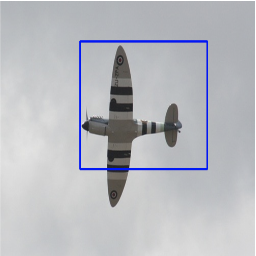

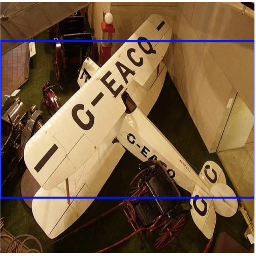

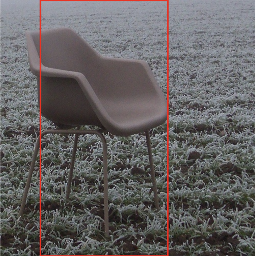

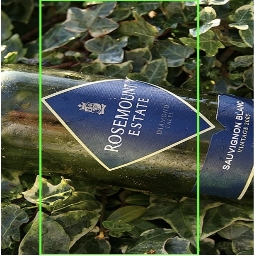

In [0]:
print('Five right predictions for 1 layer model are :')
for i in range(1,5):
    img = cv2.imread('model_1_right_'+str(i)+'.png')
    cv2_imshow(cv2.resize(img,(256,256)))

Five wrong predictions for 1 layer model are :


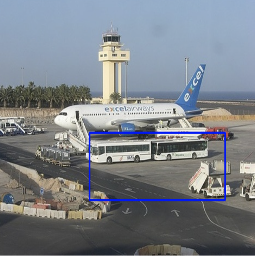

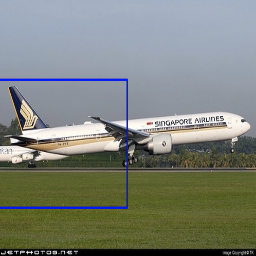

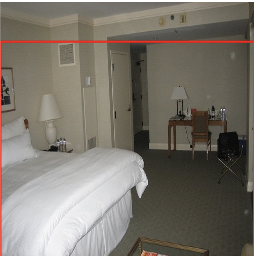

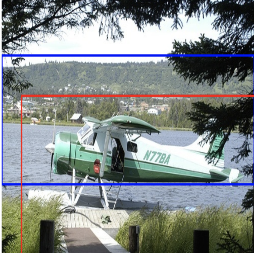

In [0]:
print('Five wrong predictions for 1 layer model are :')
for i in range(1,5):
    img = cv2.imread('model_1_wrong_'+str(i)+'.png')
    cv2_imshow(cv2.resize(img,(256,256)))

Five right predictions for final two-layered model are :


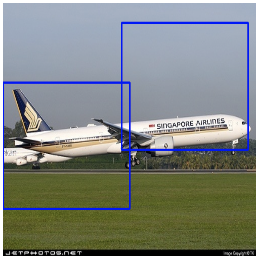

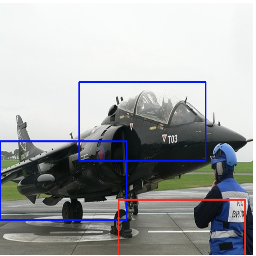

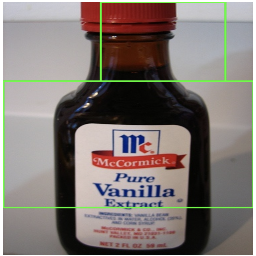

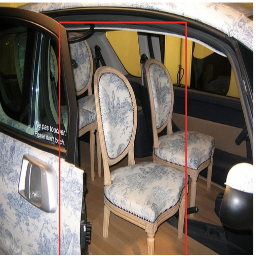

In [0]:
print('Five right predictions for final two-layered model are :')
for i in range(1,5):
    img = cv2.imread('model_2_right_'+str(i)+'.png')
    cv2_imshow(cv2.resize(img,(256,256)))

Five wrong predictions for final two-layered model are :


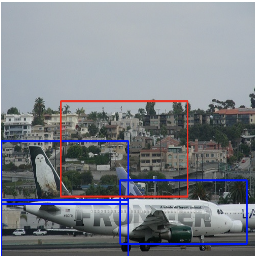

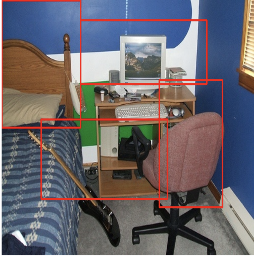

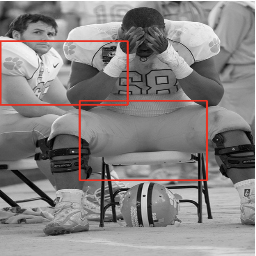

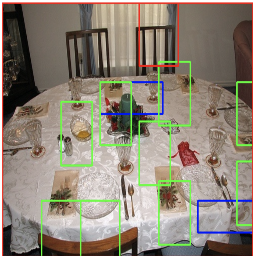

In [0]:
print('Five wrong predictions for final two-layered model are :')
for i in range(1,5):
    img = cv2.imread('model_2_wrong_'+str(i)+'.png')
    cv2_imshow(cv2.resize(img,(256,256)))